---
**Introduction to Numerical Shooting**

Week 15 of EMAT30008

https://engmaths.github.io/emat30008/odes/numericalshooting/ 

(See week15funcs.py for associated functions)

Author: Ben Winstanley, yy23737@bristol.ac.uk

---

In [2]:
import numpy as np
import scipy as sp 
import matplotlib.pyplot as plt
import os
import time

# Move to parent directory, then w14, import, change back
# TODO: make this importing less hard coded to folder names
os.chdir(os.path.pardir)
os.chdir("Week 14")
from week14funcs import euler_step, solve_to 
os.chdir(os.path.pardir)
os.chdir("Week 15")


-------
*Simulating Predator Prey Equations*

$ \frac{dx}{dt} = x(1-x) - \frac{axy}{d+x} $

$ \frac{dy}{dt} = by(1 - \frac{y}{x}) $

set a = 1, d = 0.1, b $\in [0.1,0.5]$

We'll choose x=1,y=1 as initial conditions

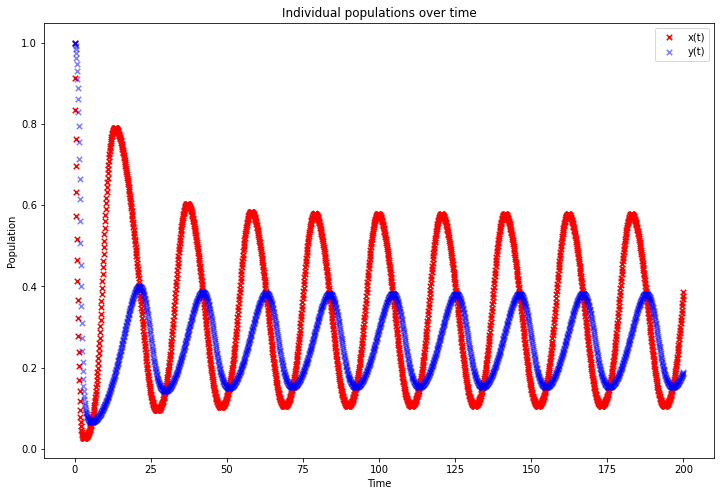

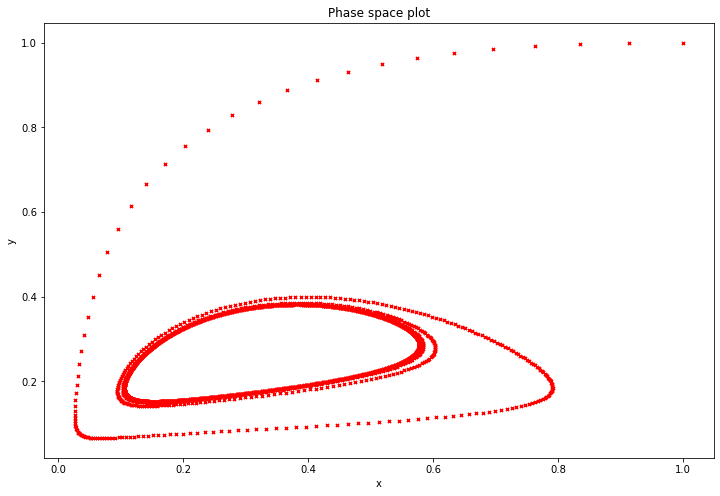

In [13]:
# Define ODE function f(x,t)
def predator_prey(x: np.ndarray, t: float):
    '''
    Defines RHS for Predator Prey system
    '''
    # Define constants inside function for now
    a = 1
    d = 0.1
    b = 0.2

    dxdt = x[0]*(1-x[0]) - (a*x[0]*x[1])/(d+x[0])
    dydt = b*x[1]*(1-(x[1]/x[0]))
    return np.array((dxdt, dydt))

# Calling solve_to with RK4 method
x_init = np.array((1,1))
solution = solve_to(predator_prey, x_init, 0, 200, 0.1, 'RK4')

plt.figure(figsize=[12,8])
plt.scatter(solution[:,0], solution[:,1], c='r', marker='x', s=30, label='x(t)')
plt.scatter(solution[:,0], solution[:,2], c='b', marker='x', s=30,label='y(t)', alpha=0.5)
plt.legend()
plt.title("Individual populations over time")
plt.xlabel("Time")
plt.ylabel("Population")
plt.show()

plt.figure(figsize=[12,8])
plt.scatter(solution[:,1], solution[:,2], c='r', marker='x', s=10)
plt.title("Phase space plot")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

For b < 0.26 the solution converges to a stable limit cycle
For b > 0.26 the solution converges to a stable equillibrium point

We fix b = 0.20 and try to ascertain the period. We look at t>100 (halfway) when it has settled. Take the value of x,y at t=100, and look for the next time it reaches near this by some threshhold. Since this is an ODE we don't bother to take an average across multiple oscillations for period

We vary the tolerance `tol` until we see a jump in the reported period. For large `tol` this will just report the next step since it's sufficiently close, so make `tol` small enough that only the next value when it exactly matches up again works.

In [20]:
# Values at 1000th step of t
fixtime, xfix, yfix = solution[1000,:]
doneflag = 1
i = 1
tol =0.001
while doneflag:
    timeval, xval, yval = solution[1000+i,:]
    if np.sqrt((xval - xfix)**2 + (yval - yfix)**2) < tol:
        doneflag = 0
        continue
    i +=1
print(timeval)
print("Period is ", round(timeval - fixtime, 2), "seconds")


120.80000000000001
Period is  20.8 seconds
